This notebook can be run on mybinder: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgricad-gitlab.univ-grenoble-alpes.fr%2Fchatelaf%2Fconference-ia/master?urlpath=lab/tree/notebooks/3_principal_component_analysis)

# Olympic decathlon data

This example is a short introduction to PCA analysis. The Data are performance marks on the ten [decathlon events](https://en.wikipedia.org/wiki/Decathlon) for 33 athletes at the Olympic Games (1988).

The code cell below defines some useful functions to display summary statistics of PCA representation

In [21]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

def scree_plot(pca):
    PC_values = np.arange(pca.n_components_) + 1
    PC_labels = ['PC' + str(nb+1) for nb in range(pca.n_components_)] 
    plt.figure(figsize=(8,6))
    plt.bar(PC_values, pca.explained_variance_, linewidth=2, edgecolor='k')
    plt.xticks(ticks=PC_values, labels=PC_labels)
    plt.title('Scree Plot')
    plt.xlabel('Principal Components')
    plt.ylabel('Explained Variance ')
    plt.show()
        
def pca_summary(pca, X, out=True):
    """Display a table of the explained std, proportion of variance, 
    and proportion of variance ratio for each component
    """
    names = ["PC"+str(i) for i in range(1, len(pca.explained_variance_ratio_)+1)]
    a = list(np.std(pca.transform(X), axis=0, ddof=1))
    b = list(pca.explained_variance_ratio_)
    c = [np.sum(pca.explained_variance_ratio_[:i]) for i in range(1, len(pca.explained_variance_ratio_)+1)]
    columns = pd.MultiIndex.from_tuples([("sdev", "Standard deviation"), ("varprop", "Proportion of Variance"), ("cumprop", "Cumulative Proportion")])
    summary = pd.DataFrame(list(zip(a, b, c)), index=names, columns=columns)
    if out:
        print("Importance of components:")
        display(summary)
    return summary

def biplot2D(score,coeff,labels=None):
    """Generate biplot for the first two principal components 
    to display both scores and variables
    """
    
    xs = score[:,0] # projection on PC1
    ys = score[:,1] # projection on PC2
    p = coeff.shape[1]
    n = score.shape[0]
    
    fig, ax = plt.subplots(figsize=(10,8))
    # plot the scores with the index of the sample
    ax.scatter(xs, ys, marker=".", color = 'k')
    for i in range(33):
        ax.text(xs[i], ys[i], str(i), color = 'k')
    ax.set_xlabel("PC{}".format(1))
    ax.set_ylabel("PC{}".format(2))
    
    # plot the variable vectors (arrow) in the PC plane (loadings)  
    arrow_sc = 1.15 
    color = 'tab:red'
    ax2 = ax.twinx() # instantiate a second x axe
    ax2.set_ylim(-1.2,1.2)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2 = ax2.twiny() # instantiate a second y axe
    ax2.set_xlim(-1.2,1.2)
    ax2.tick_params(axis='x', labelcolor=color)
    for i in range(p):
        ax2.arrow(0, 0, coeff[0, i], coeff[1, i], color =  color ,alpha = 0.5, 
                  linestyle = '-',linewidth = 1.5, head_width=0.02, head_length=0.02)
        if labels is None:
            ax2.text(coeff[0, i]* arrow_sc, coeff[1,i] * arrow_sc, "Var"+str(i+1), 
                     color = color, ha = 'center', va = 'center')
        else:
            ax2.text(coeff[0, i]* arrow_sc, coeff[1, i] * arrow_sc, labels[i], 
                     color = color, ha = 'center', va = 'center')

## Dataset

#### Load olympic dataset contained in the text file `olympic.csv` (*Warning:* copy  this data file in the notebook directory)

In [2]:
import pandas as pd
import numpy as np


#load data set
olympic = pd.read_csv('olympic.csv', sep=',', header=0)
olympic.head() #data overview: variable names and first rows

,100,long,poid,haut,400,110,disq,perc,jave,1500
0,11.25,7.43,15.48,2.27,48.90,15.13,49.28,4.7,61.32,268.95
1,10.87,7.45,14.97,1.97,47.71,14.46,44.36,5.1,61.76,273.02
2,11.18,7.44,14.20,1.97,48.29,14.81,43.66,5.2,64.16,263.20
3,10.62,7.38,15.02,2.03,49.06,14.72,44.80,4.9,64.04,285.11
4,11.02,7.43,12.92,1.97,47.44,14.40,41.20,5.2,57.46,256.64


#### Display some descriptive statistics for this dataset

In [3]:
olympic.describe()

,100,long,poid,haut,400,110,disq,perc,jave,1500
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,11.196364,7.133333,13.976364,1.982727,49.276667,15.048788,42.353939,4.739394,59.438788,276.038485
std,0.243321,0.304340,1.331991,0.093984,1.069660,0.506765,3.719131,0.334421,5.495998,13.657098
min,10.620000,6.220000,10.270000,1.790000,47.440000,14.180000,34.360000,4.000000,49.520000,256.640000
25%,11.020000,7.000000,13.150000,1.940000,48.340000,14.720000,39.080000,4.600000,55.420000,266.420000
50%,11.180000,7.090000,14.120000,1.970000,49.150000,15.000000,42.320000,4.700000,59.480000,272.060000
75%,11.430000,7.370000,14.970000,2.030000,49.980000,15.380000,44.800000,4.900000,64.000000,286.040000
max,11.570000,7.720000,16.600000,2.270000,51.280000,16.200000,50.660000,5.700000,72.600000,303.170000


We can guess on the table above that the *running* event performances are measured in seconds, while the *jumping* or *throwing* ones are in meters.

## PCA

Make *PCA* on decathlon event scores data $X \in \mathbb{R}^{n \times p}$: $n=33$ samples (athletes), $p=10$ variables/features (decathlon events)

In [4]:
from sklearn.decomposition import PCA
pca = PCA()
olympic_pc = pca.fit_transform(olympic) # get the Principal components

How is the distribution of component variances/eigenvalues $\lambda_i^2$, $1 \le i \le p$ ? Let's visualize the **screeplot**

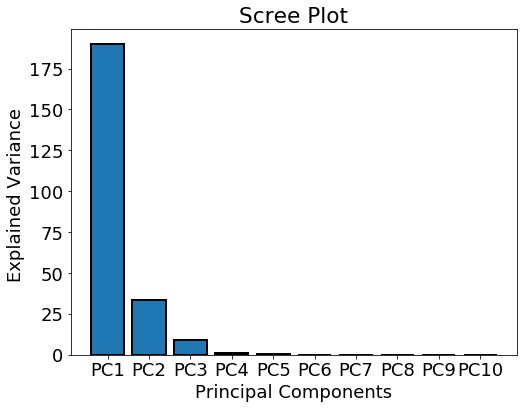

In [19]:
scree_plot(pca)

#### Display a summary of PCA representation

In [6]:
pca_summary(pca, olympic) ;

Importance of components:


,sdev,varprop,cumprop
,Standard deviation,Proportion of Variance,Cumulative Proportion
PC1,13.780719,0.811567,0.811567
PC2,5.804303,0.143973,0.955540
PC3,2.960659,0.037459,0.992999
PC4,0.940615,0.003781,0.996780
PC5,0.698113,0.002083,0.998863
PC6,0.346530,0.000513,0.999376
PC7,0.247437,0.000262,0.999637
PC8,0.231472,0.000229,0.999866
PC9,0.156289,0.000104,0.999971


#### Dsiplay the biplot

The *biplot* gives a graphical summary of both samples (athletes) in terms of scores and the
variables/features in terms of loadings


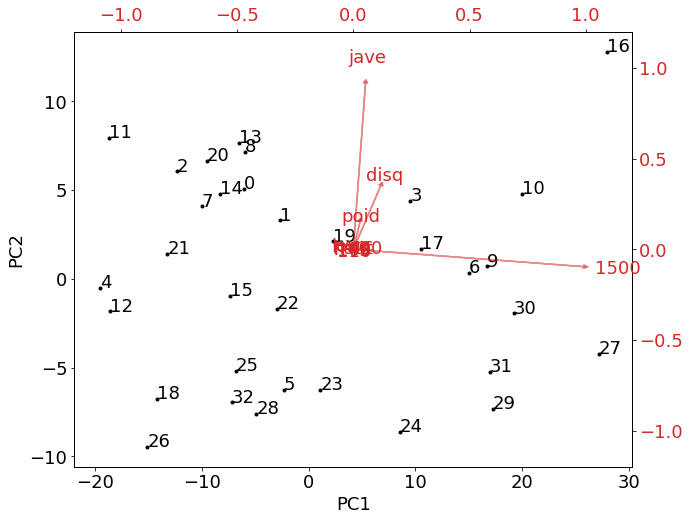

In [7]:
#Call the function. Use only the 2 PCs.
biplot2D(olympic_pc[:,0:2], pca.components_[0:2, :], olympic.columns)
plt.show()

From this plot above, we see that the first principal component is positively associated with longer times on the 1500.  

We can compare the athlete '1500' event mark with their score with the first component to check that slower runners will have higher value on this component, and vice versa.

In [8]:
print('Average 1500 event mark (seconds) == {:.2f}'.format(olympic['1500'].mean()) )
pd.DataFrame(list(zip(olympic['1500'],olympic_pc[:,0])), columns=['1500', 'score PC1'])

Average 1500 event mark (seconds) == 276.04


,1500,score PC1
0,268.95,-6.073747
1,273.02,-2.678254
2,263.20,-12.350157
3,285.11,9.526886
4,256.64,-19.567241
5,274.07,-2.312197
6,291.20,15.048108
7,265.86,-10.023305
8,269.62,-5.976738
9,292.24,16.717007


Text(0, 0.5, 'PC1')

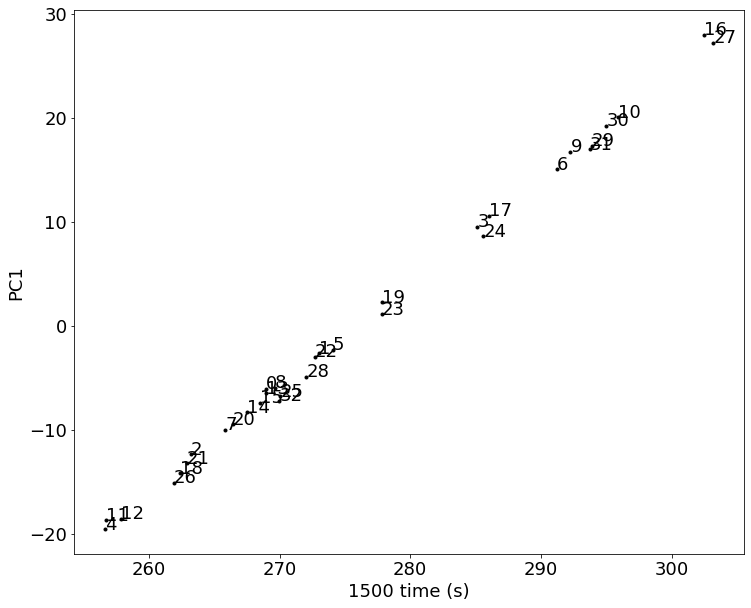

In [9]:
plt.figure(figsize=(12,10))
plt.plot(olympic['1500'],olympic_pc[:,0],'k.')
for i in range(len(olympic_pc[:,0])):
    plt.text(olympic['1500'][i], olympic_pc[i,0], str(i), color = 'k')
plt.xlabel('1500 time (s)')
plt.ylabel('PC1')

So the correlation is almost perfect between the `1500`event and the first principal component!

Moreover, the previous biplot shows that the *second main component* is correlated with the force in the form of a long *javelin* throw.

Text(0, 0.5, 'PC2')

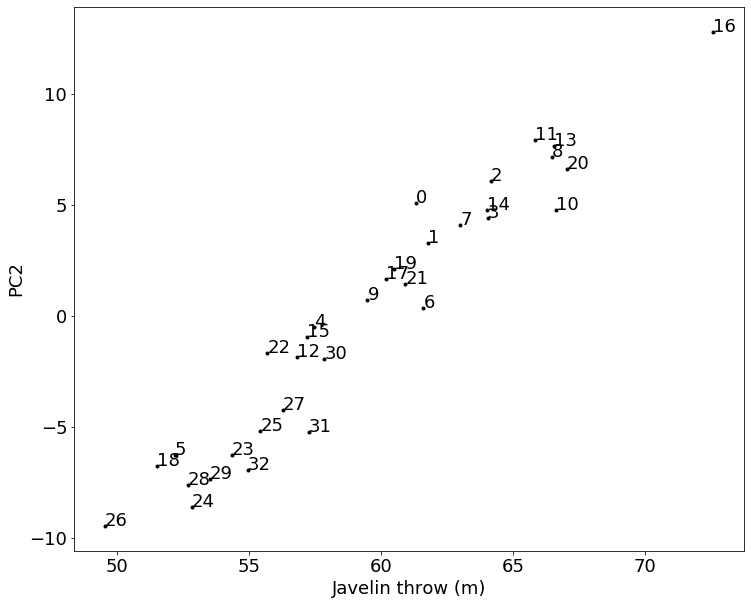

In [10]:
plt.figure(figsize=(12,10))
plt.plot(olympic['jave'],olympic_pc[:,1],'k.')
for i in range(len(olympic_pc[:,0])):
    plt.text(olympic['jave'][i], olympic_pc[i,1], str(i), color = 'k')
plt.xlabel('Javelin throw (m)')
plt.ylabel('PC2')

We can check in the plot above that stronger throwers will have higher value on this second component.

## Standardizing: scale matters!

In the previous example, we saw that the two variables were based somewhat on speed and strength. However, 
**we did not scale the variables** so the 1500 has much more weight than the 400, for instance! 

We correct this by standardizing the variables with `sklearn` preprocessor methods

In [11]:
from sklearn.preprocessing import StandardScaler

# Center and reduce the variables
scaler = StandardScaler()
Xs = scaler.fit_transform(olympic)

# Make PCA on standardized variables
pca_s = PCA() # estimate only 2 PCs
Xs_pc = pca_s.fit_transform(Xs) # project the original data into the PCA space

Show the new biplot for the standardized variables

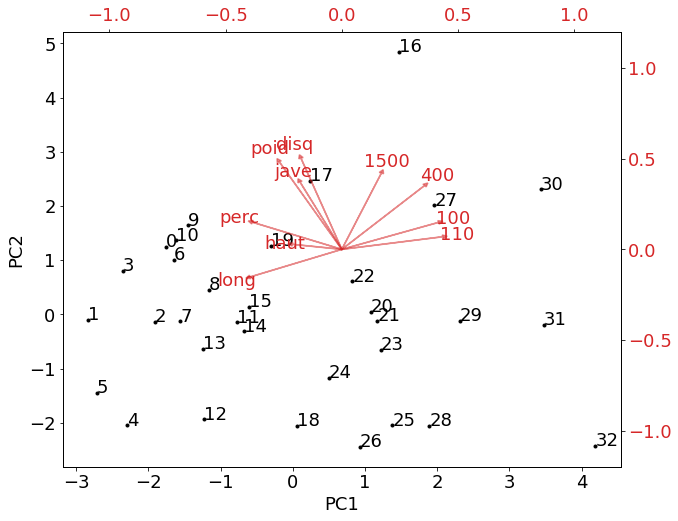

In [12]:
#Call the function. Use only the 2 PCs.
biplot2D(Xs_pc[:,0:2], pca_s.components_[0:2, :], olympic.columns)
plt.show()

By standardizing, this plot above reinforces our earlier interpretation by grouping sprint events (as *100m*,
*110m*, *400m*, *long*) along a same axis aligned with the first principal  

Likewise the strength and throwing events (in french, *javelot*, *disque*, *poids*)lies on a separate axis rather aligned on the second component (thus rather decorrelated from the previous one).

### Display the loadings

In [13]:
pca_s.components_[0:2, :]
pd.DataFrame(pca_s.components_[0:2, :].T, columns=['PC1', 'PC2'], index=olympic.columns)

,PC1,PC2
100,0.415882,0.148808
long,-0.394051,-0.152082
poid,-0.269106,0.483537
haut,-0.212282,0.027898
400,0.355847,0.352160
110,0.433482,0.069568
disq,-0.175792,0.503335
perc,-0.384082,0.149582
jave,-0.179944,0.371957
1500,0.170143,0.420965


## Exercise
- For the *non-standardized* olympic data, explain why the `1500` event is the more important to explain the variance. Is is still true after standardization?
- Explain how many components do you think are sufficient to explain the *non-standardized* olympic data? Do you think the same is true for tje standardized data?
- From the biplot analysis in the *standardized* case what are the global meanings of the first two principal components?  Are the loadings consistent with these conclusions?
- In your opinion, is it better (i.e. more useful) to perform PCA on *standardized* or *non-standardized* data for this example?